In [1]:
import os, sys
import glob
import numpy as np
import pandas as pd
import joblib

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [2]:
def binning(bin_var, bin_min, bin_max, n_bin):
    bin_xs = np.concatenate(([-np.inf], np.linspace(bin_min, bin_max, n_bin + 1), [np.inf]), axis=0)
    bin_step = bin_xs[2] - bin_xs[1]
    bin_centers = []
    for i in range(1, len(bin_xs) - 2):
        bin_centers.append((bin_xs[i] + bin_xs[i+1]) / 2)
    bin_centers = np.concatenate(([bin_centers[0] - bin_step], bin_centers, [bin_centers[-1] + bin_step]), axis=0)
    
    bin_indices = np.digitize(bin_var, bin_xs) - 1
    bin_masks = [(bin_indices == i) for i in range(len(bin_xs) - 1)]
    return bin_xs, bin_centers, bin_masks


def plot_n_matches(
    var, var_min, var_max, n_bin,
    xlabel, ylabel, title,
    output_path,
):
    bin_xs, bin_centers, bin_masks = binning(var, var_min, var_max, n_bin)
    bin_step = bin_xs[2] - bin_xs[1]
    mean_n_Y = []
    mean_n_Y_pred = []

    for bin_mask in bin_masks:
        mean_n_Y.append(n_Y[bin_mask].mean())
        mean_n_Y_pred.append(n_Y_pred[bin_mask].mean())

    plt.figure(figsize=(8, 5))
    plt.bar(
        bin_centers,
        mean_n_Y_pred,
        width=bin_step,
        label=r'$N\ Matches_{Predict}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='\\',
        alpha=0.6
    )

    plt.bar(
        bin_centers,
        mean_n_Y,
        width=bin_step,
        label=r'$N\ Matches_{Data}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='/',
        alpha=0.6
    )

    plt.xlim(bin_centers[1] - bin_step, bin_centers[-2] + bin_step)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend()
    plt.savefig(output_path)


def plot_n_false_matches(
    var, var_min, var_max, n_bin,
    xlabel, ylabel, title,
    output_path,    
):
    bin_xs, bin_centers, bin_masks = binning(var, var_min, var_max, n_bin)
    bin_step = bin_xs[2] - bin_xs[1]

    mean_n_only_data, mean_n_only_pred = [], []
    
    for bin_mask in bin_masks:
        mean_n_only_data.append(n_only_data[bin_mask].mean())
        mean_n_only_pred.append(n_only_pred[bin_mask].mean())
    
    plt.figure(figsize=(8, 5))
    
    plt.bar(
        bin_centers,
        mean_n_only_data,
        bottom=mean_n_only_pred,
        width=bin_step,
        alpha=0.6,
        label='Missed Detector',
        edgecolor='black',
        linewidth=1.0,
        hatch='/',
    )
    
    plt.bar(
        bin_centers,
        mean_n_only_pred,
        width=bin_step,
        alpha=0.6,
        label='False Predict Detector',
        edgecolor='black',
        linewidth=1.0,
        hatch='\\',
    )

    plt.xlim(bin_centers[1] - bin_step, bin_centers[-2] + bin_step)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.legend()
    plt.savefig(output_path)


def plot_ratio_matches(
    var, var_min, var_max, n_bin,
    xlabel, ylabel, title,
    output_path,
):
    bin_xs, bin_centers, bin_masks = binning(var, var_min, var_max, n_bin)
    bin_step = bin_xs[2] - bin_xs[1]
    
    no_diff_ratio, data_in_pred_ratio = [], []
    for bin_mask in bin_masks:
        unique, count = np.unique(n_diff[bin_mask], return_counts=True)
        no_diff_ratio.append(count[0] / count.sum() if len(count) != 0 else 0)

        unique, count = np.unique(n_only_data[bin_mask], return_counts=True)
        data_in_pred_ratio.append(count[0] / count.sum() if len(count) != 0 else 0)

    plt.figure(figsize=(8, 5))

    plt.bar(
        bin_centers,
        data_in_pred_ratio,
        width=bin_step,
        alpha=0.6,
        label=r'$Det_{Data} \subset Det_{Predict}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='/',
    )

    plt.bar(
        bin_centers,
        no_diff_ratio,
        width=bin_step,
        alpha=0.6,
        label=r'$Det_{Data} = Det_{Predict}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='\\',
    )

    plt.xlim(bin_centers[1] - bin_step, bin_centers[-2] + bin_step)
    plt.ylim(0, 1.0)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend()
    plt.savefig(output_path)

In [6]:
data_dir = '/users/hep/eigen1907/STORE/TrackDetMatches'
detid_table_path = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-det_raw_id/matched_det_raw_id.csv'
input_model_dir = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-XGBoost/model/file300-e100-d5-lr0.1'

model = XGBClassifier()
model.load_model(os.path.join(input_model_dir, 'model.json'))
track_scaler = joblib.load(os.path.join(input_model_dir, 'scaler.pkl'))
detid_encoder = joblib.load(os.path.join(input_model_dir, 'encoder.pkl'))

eval_paths = sorted(glob.glob(os.path.join(data_dir, '*.csv')))[-100:]
df_list = [pd.read_csv(eval_path) for eval_path in eval_paths]
df = pd.concat(df_list, ignore_index=True)
df['det_raw_id'] = df['det_raw_id'].apply(lambda x: list(map(int, x.split(' ')[:-1])))

X = track_scaler.transform(df[['track_pt', 'track_eta', 'track_phi']].values)
Y = detid_encoder.transform(df['det_raw_id'])
Y_pred_proba = model.predict_proba(X)

/tmp/ipykernel_1957557/3836388693.py:25: RuntimeWarning: Mean of empty slice.
  mean_n_Y.append(n_Y[bin_mask].mean())
/users/hep/eigen1907/micromamba/envs/torch-cpu/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1957557/3836388693.py:26: RuntimeWarning: Mean of empty slice.
  mean_n_Y_pred.append(n_Y_pred[bin_mask].mean())
/tmp/ipykernel_1957557/3836388693.py:72: RuntimeWarning: Mean of empty slice.
  mean_n_only_data.append(n_only_data[bin_mask].mean())
/tmp/ipykernel_1957557/3836388693.py:73: RuntimeWarning: Mean of empty slice.
  mean_n_only_pred.append(n_only_pred[bin_mask].mean())
/tmp/ipykernel_1957557/3836388693.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fig

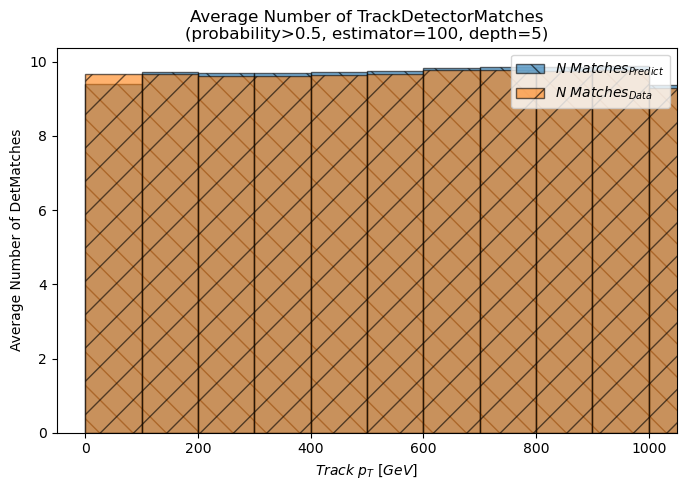

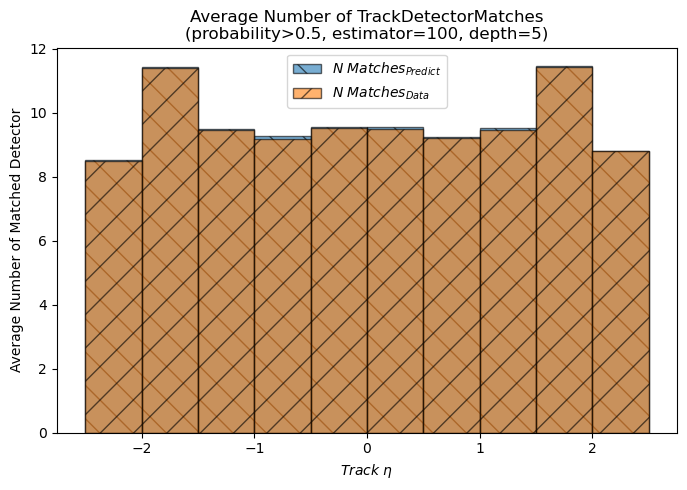

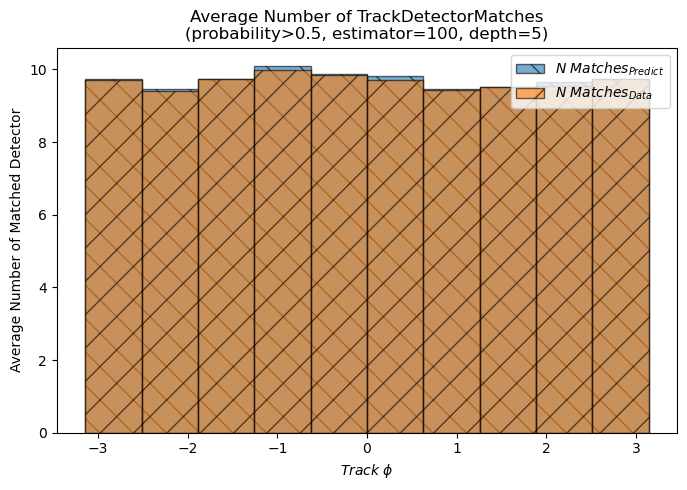

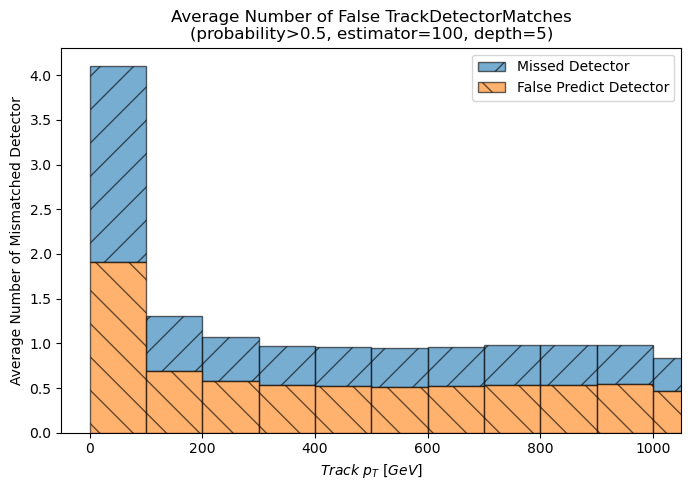

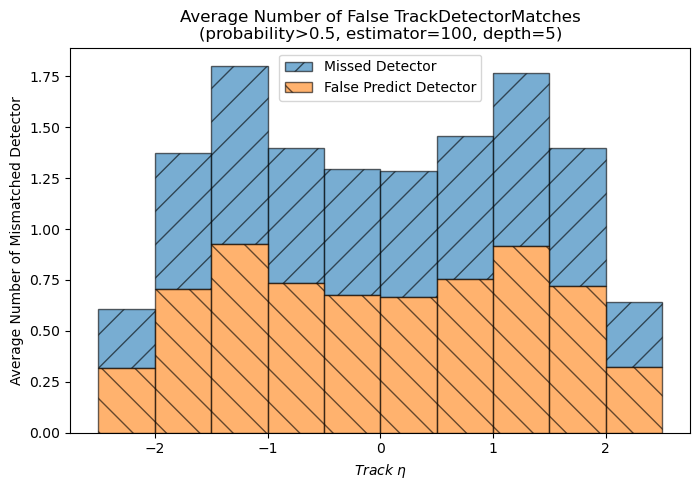

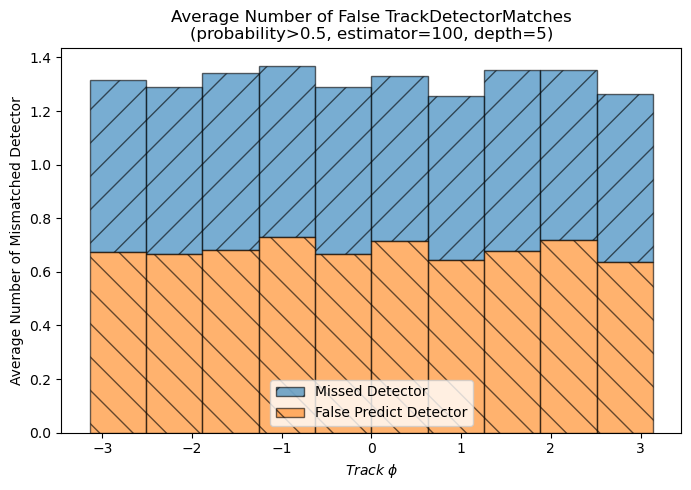

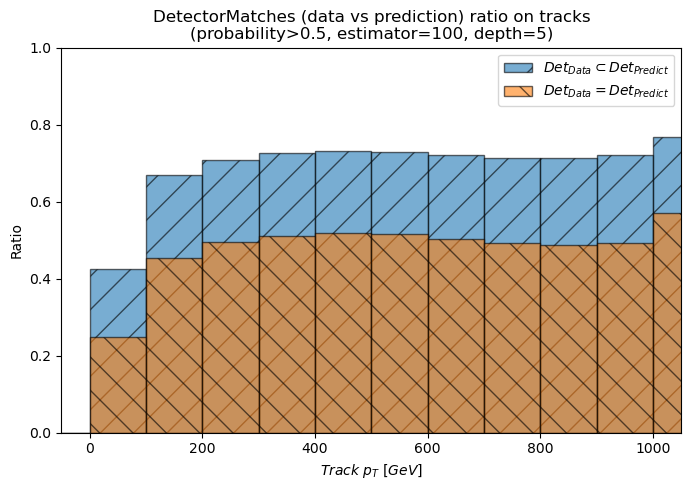

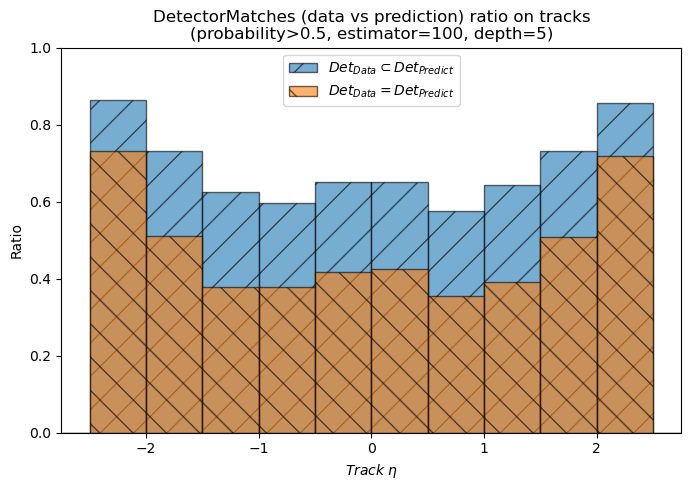

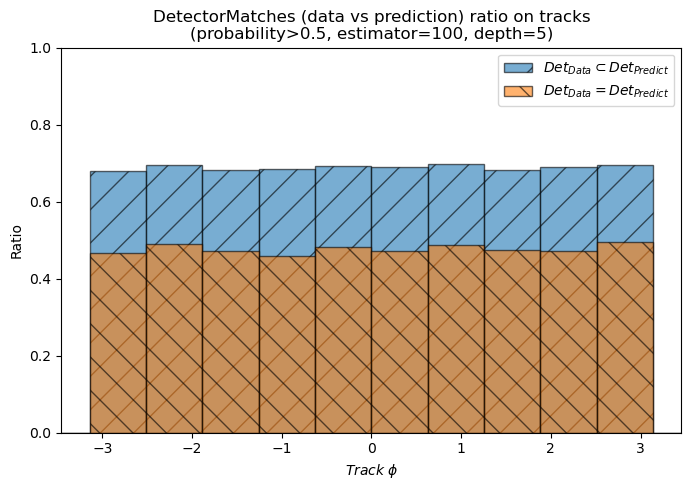

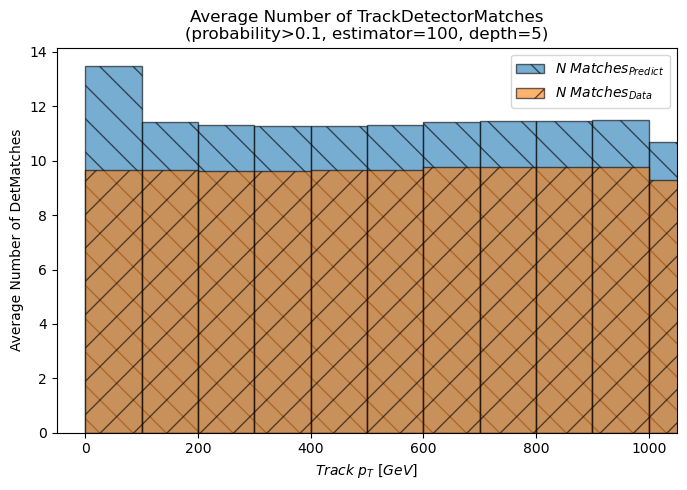

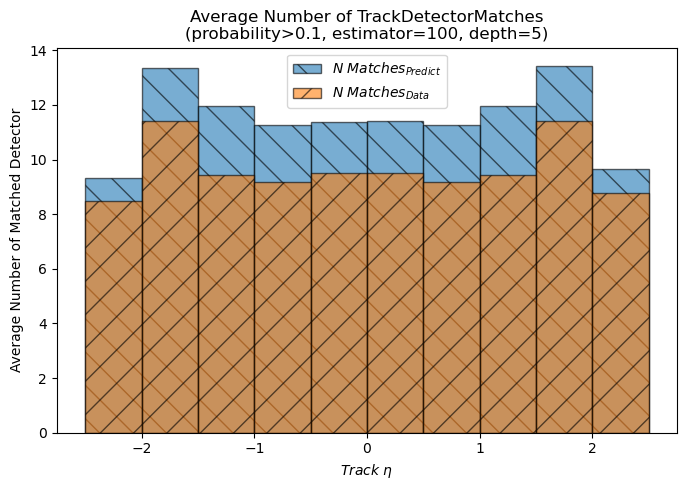

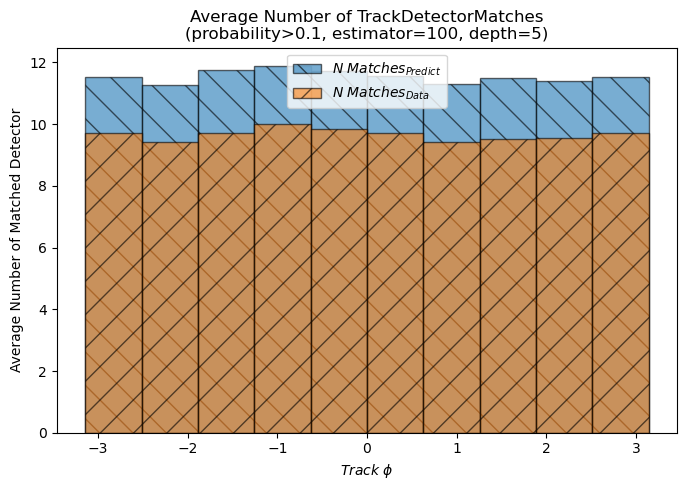

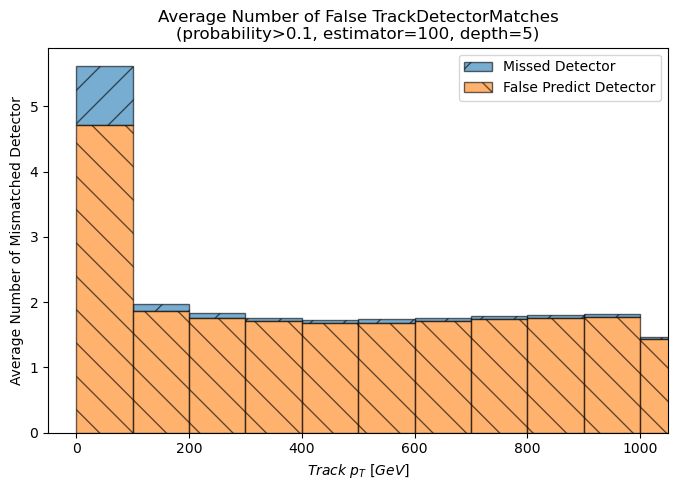

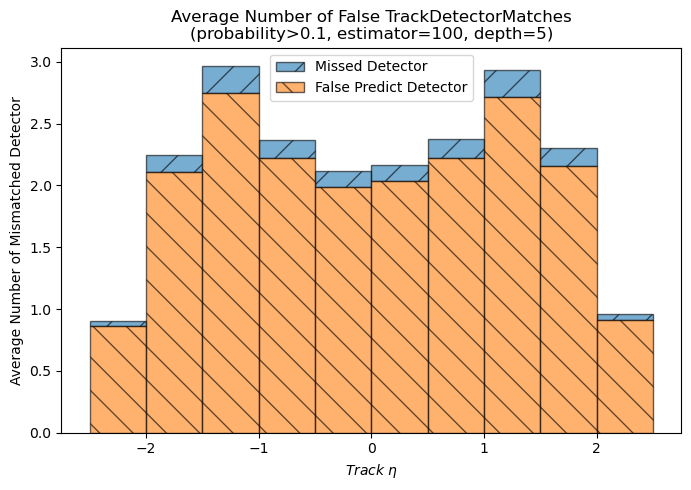

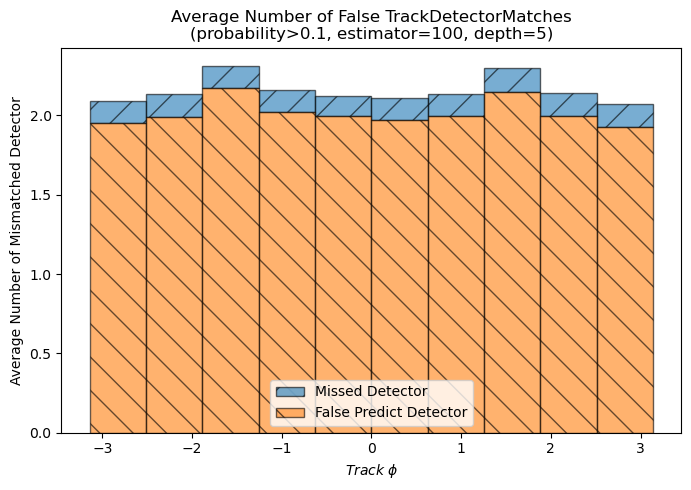

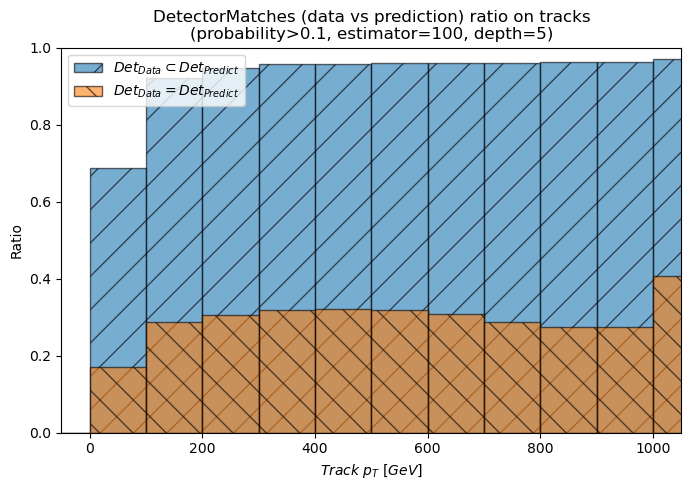

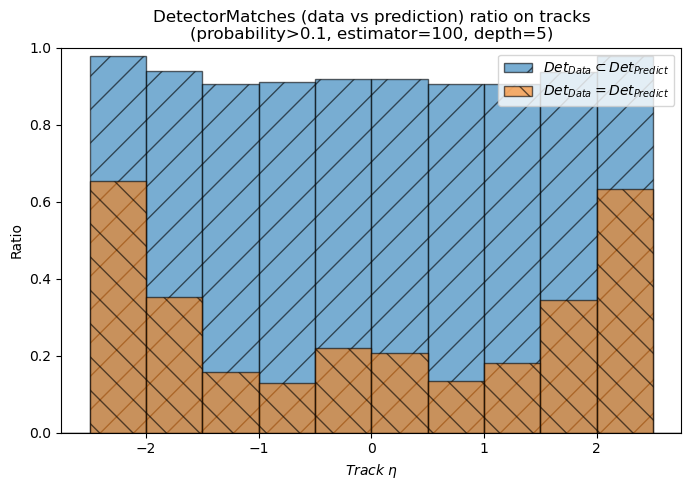

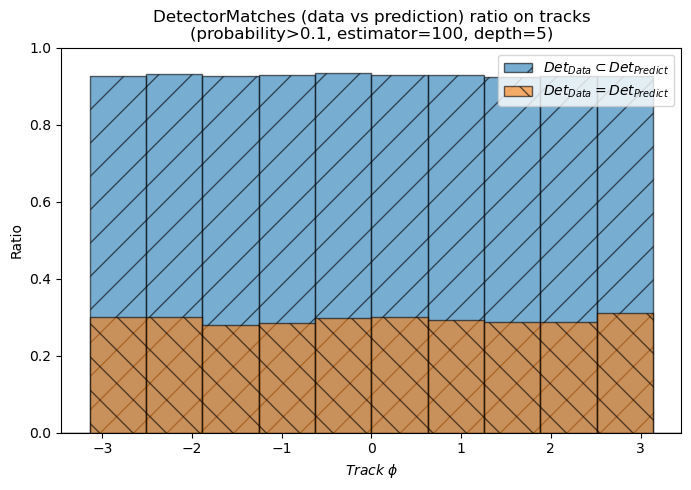

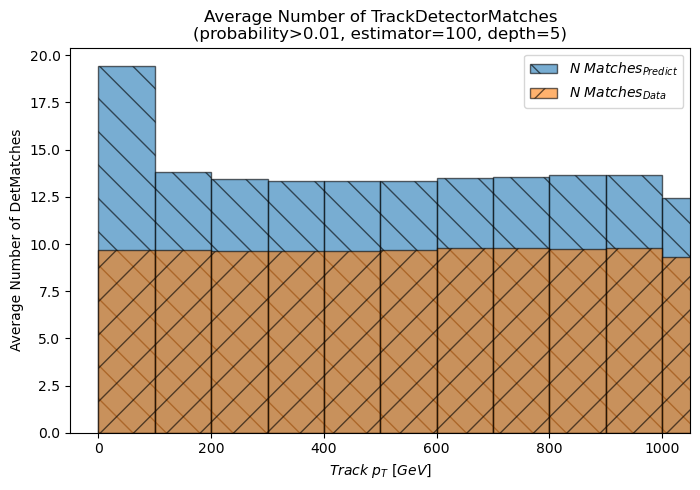

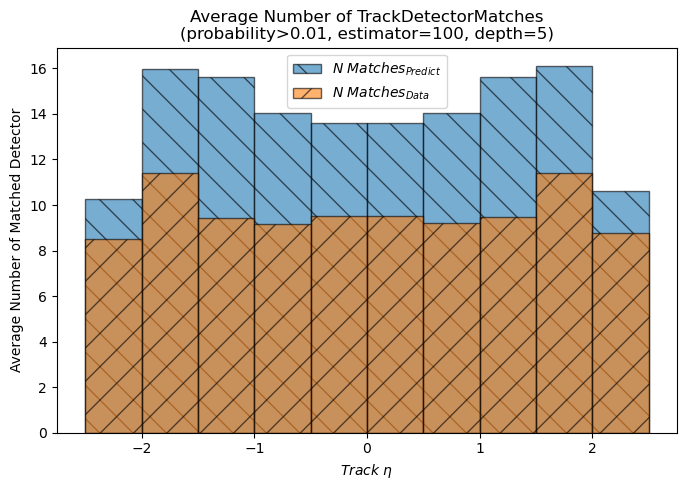

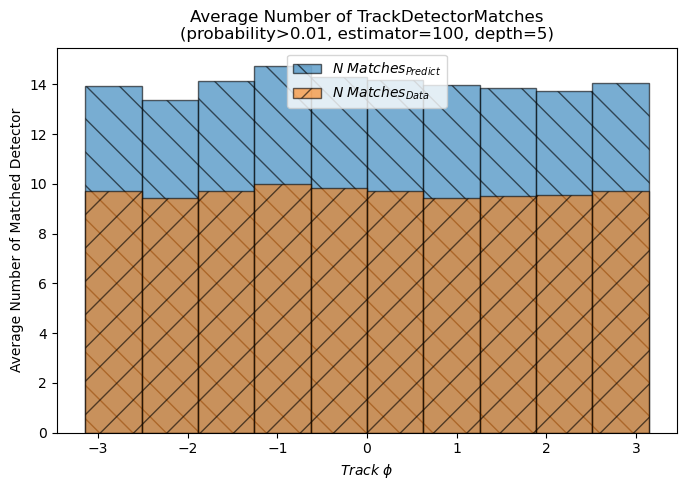

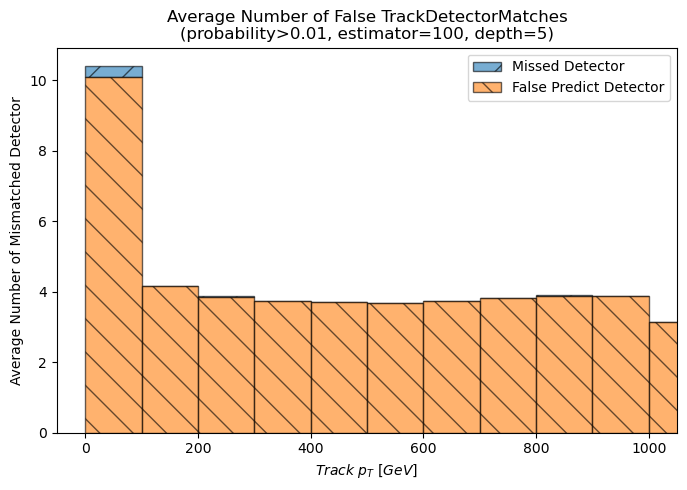

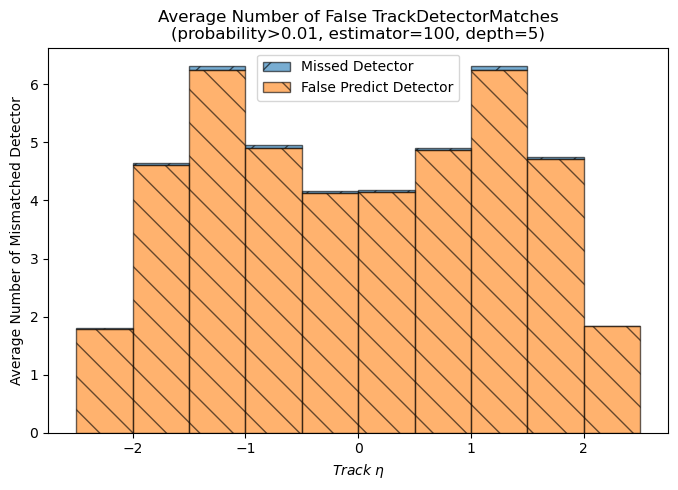

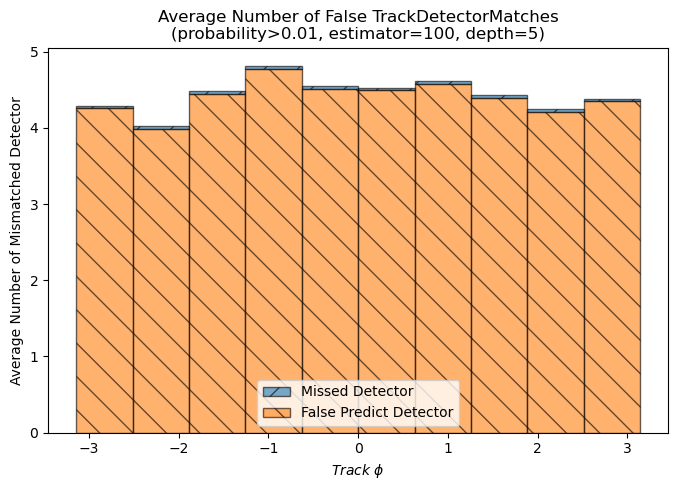

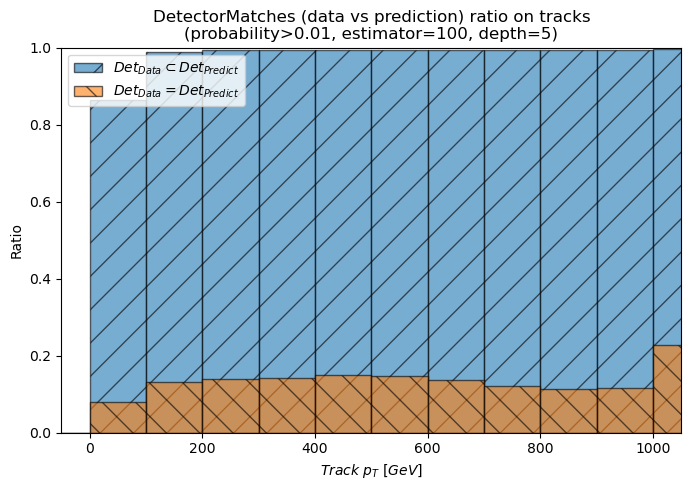

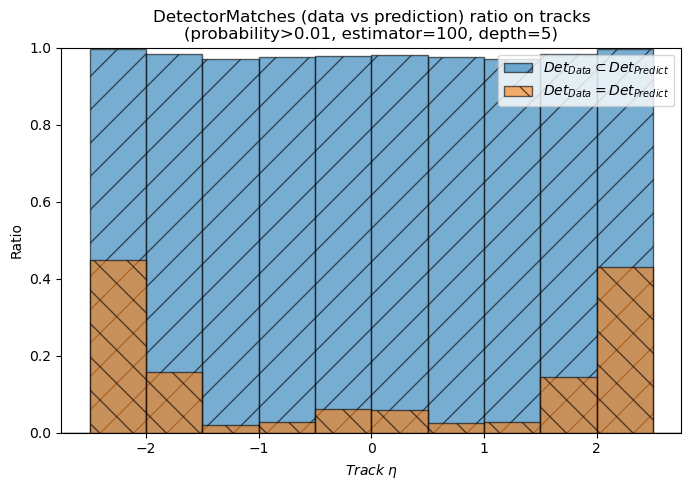

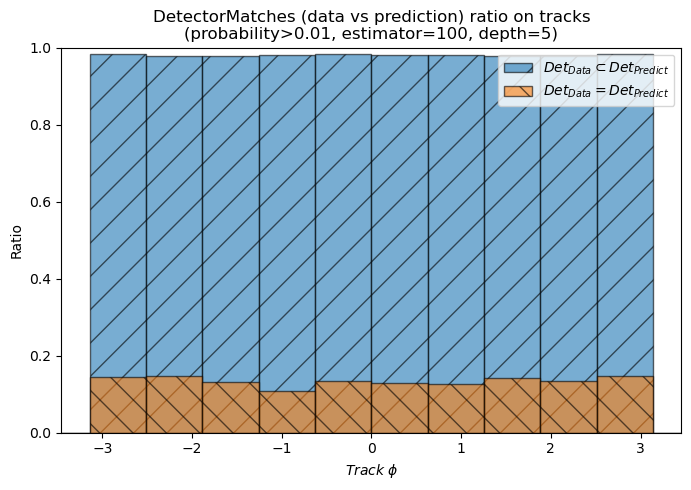

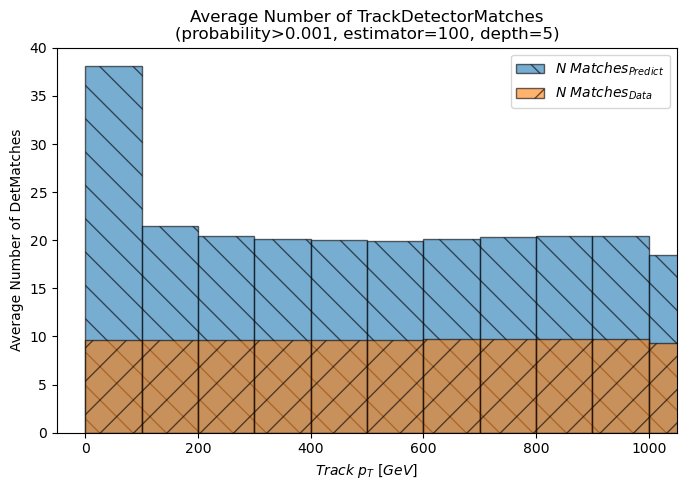

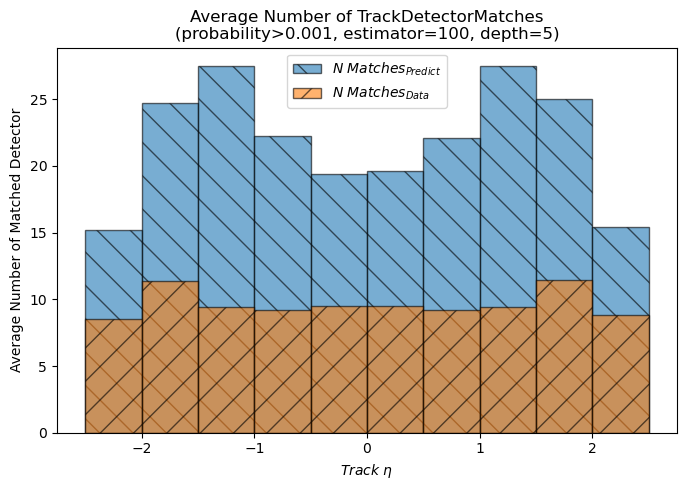

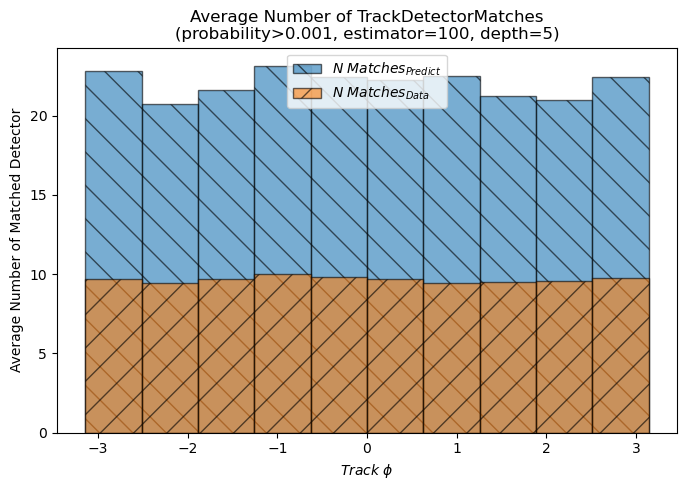

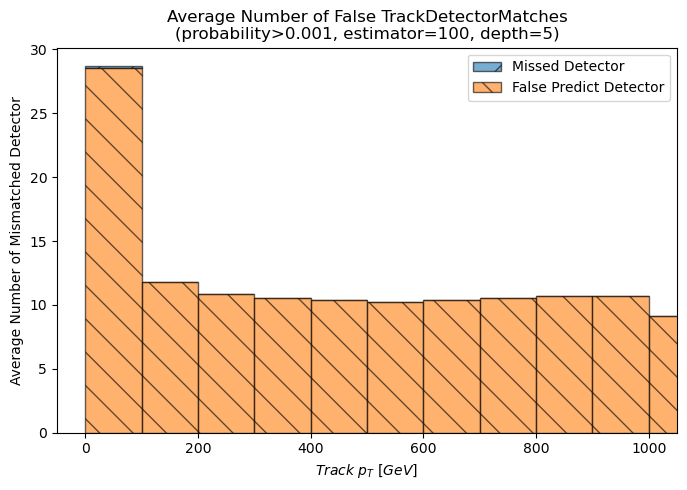

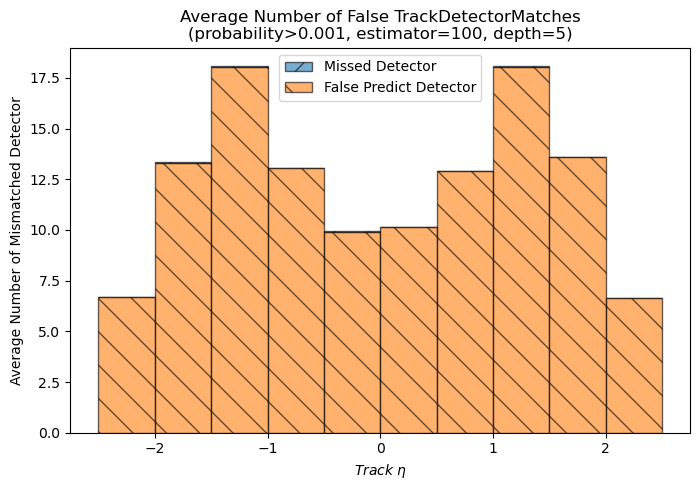

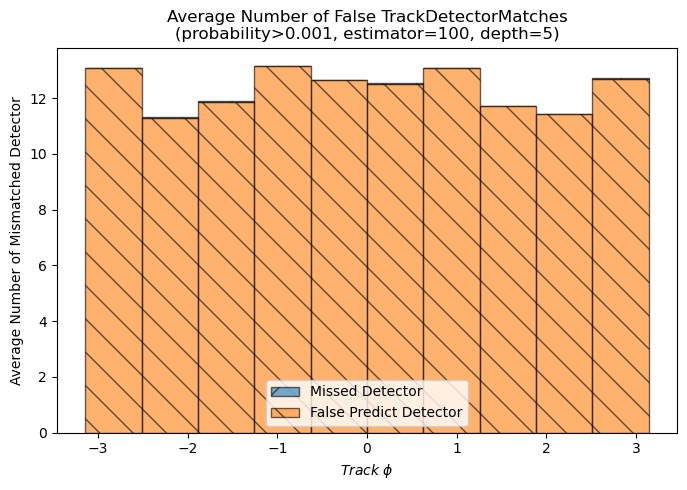

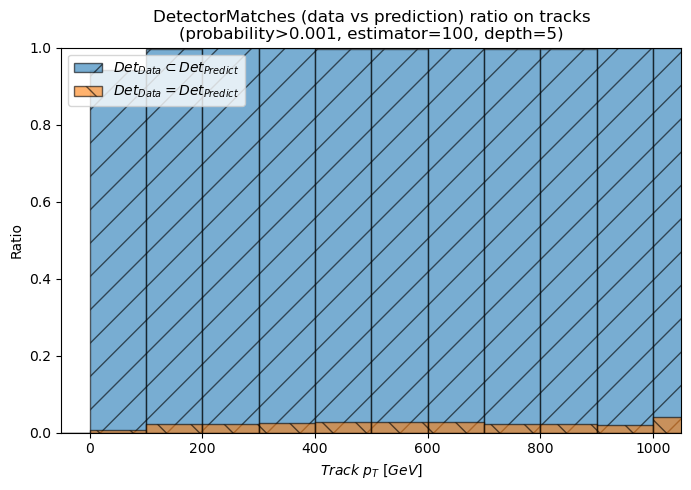

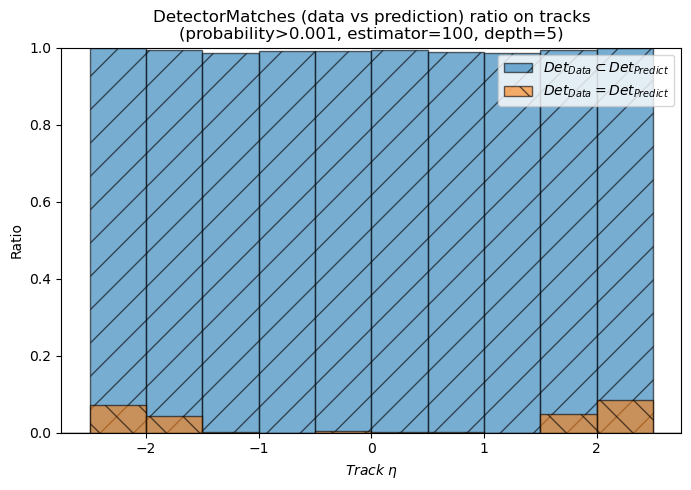

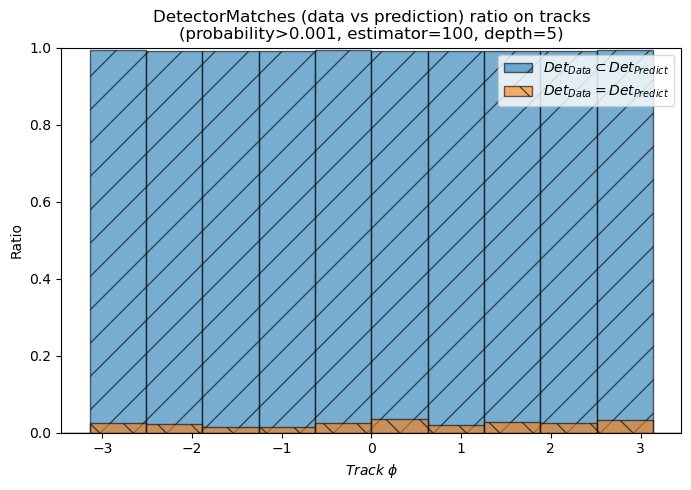

In [8]:
n_bin = 10
prob_cuts = [0.5, 0.1, 0.01, 0.001]

output_dir = f'/users/hep/eigen1907/Workspace/Workspace-DL/250102-plotting/plots-bin{n_bin}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for prob_cut in prob_cuts:
    Y_pred = (Y_pred_proba > prob_cut).astype(int)

    track_pt = df['track_pt'].values
    track_eta = df['track_eta'].values
    track_phi = df['track_phi'].values

    n_Y = Y.sum(axis=1)
    n_Y_pred = Y_pred.sum(axis=1)
    n_diff = (Y != Y_pred).sum(axis=1)
    n_only_data = (Y > Y_pred).sum(axis=1)
    n_only_pred = (Y < Y_pred).sum(axis=1)


    plot_n_matches(
        var=track_pt, var_min=0, var_max=1000, n_bin=n_bin,
        xlabel=r'$Track\ p_{T}\ [GeV]$', 
        ylabel='Average Number of DetMatches',
        title=f'Average Number of TrackDetectorMatches\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/match-pt-p{prob_cut}.png',
    )

    plot_n_matches(
        var=track_eta, var_min=-2.5, var_max=2.5, n_bin=n_bin,
        xlabel=r'$Track\ \eta$',
        ylabel='Average Number of Matched Detector',
        title=f'Average Number of TrackDetectorMatches\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/match-eta-p{prob_cut}.png'
    )

    plot_n_matches(
        var=track_phi, var_min=-np.pi, var_max=np.pi, n_bin=n_bin,
        xlabel=r'$Track\ \phi$',
        ylabel='Average Number of Matched Detector',
        title=f'Average Number of TrackDetectorMatches\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/match-phi-p{prob_cut}.png'
    )

    plot_n_false_matches(
        var=track_pt, var_min=0, var_max=1000, n_bin=n_bin,
        xlabel=r'$Track\ p_{T}\ [GeV]$', 
        ylabel='Average Number of Mismatched Detector',
        title=f'Average Number of False TrackDetectorMatches\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/falsematch-pt-p{prob_cut}.png',
    )

    plot_n_false_matches(
        var=track_eta, var_min=-2.5, var_max=2.5, n_bin=n_bin,
        xlabel=r'$Track\ \eta$',
        ylabel='Average Number of Mismatched Detector',
        title=f'Average Number of False TrackDetectorMatches\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/falsematch-eta-p{prob_cut}.png'
    )

    plot_n_false_matches(
        var=track_phi, var_min=-np.pi, var_max=np.pi, n_bin=n_bin,
        xlabel=r'$Track\ \phi$',
        ylabel='Average Number of Mismatched Detector',
        title=f'Average Number of False TrackDetectorMatches\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/falsematch-phi-p{prob_cut}.png'
    )

    plot_ratio_matches(
        var=track_pt, var_min=0, var_max=1000, n_bin=n_bin,
        xlabel=r'$Track\ p_{T}\ [GeV]$', 
        ylabel='Ratio',
        title=f'DetectorMatches (data vs prediction) ratio on tracks\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/ratio-pt-p{prob_cut}.png',    
    )

    plot_ratio_matches(
        var=track_eta, var_min=-2.5, var_max=2.5, n_bin=n_bin,
        xlabel=r'$Track\ \eta$', 
        ylabel='Ratio',
        title=f'DetectorMatches (data vs prediction) ratio on tracks\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/ratio-eta-p{prob_cut}.png',    
    )

    plot_ratio_matches(
        var=track_phi, var_min=-np.pi, var_max=np.pi, n_bin=n_bin,
        xlabel=r'$Track\ \phi$', 
        ylabel='Ratio',
        title=f'DetectorMatches (data vs prediction) ratio on tracks\n(probability>{prob_cut}, estimator=100, depth=5)',
        output_path=f'{output_dir}/ratio-phi-p{prob_cut}.png',    
    )